# Dask

user installation:
``` bash
python3 -m pip install --upgrade "dask[complete]"
```
or system-wide installation:
``` bash
sudo -H python3 -m pip install --upgrade "dask[complete]"
```

## Dask delayed

In [1]:
from dask import delayed, compute
import dask

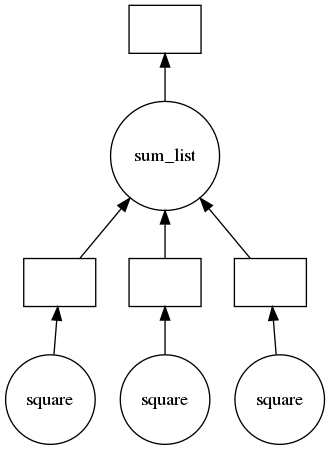

In [2]:
@delayed
def square(num):
    print("square fn:", num)
    print()
    return num * num

@delayed
def sum_list(args):
    print("sum_list fn:", args)
    return sum(args)

items = [1, 2, 3]

computation_graph = sum_list([square(i) for i in items])

computation_graph.visualize()

In [3]:
print("Result", computation_graph.compute())

square fn: 1

square fn: 2

square fn: 3

sum_list fn: [1, 4, 9]
Result 14


## Embarrassingly parallel applications

In [21]:
from dask.distributed import Client, progress
# client = Client(threads_per_worker=2, n_workers=1)
client = Client('tcp://10.31.210.110:8786')
client

Client Scheduler: tcp://10.31.210.110:8786 Dashboard: http://10.31.210.110:8787/status,Cluster Workers: 1 Cores: 32 Memory: 135.15 GB


In [22]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [23]:
%time costly_simulation([1, 2, 3, 4])

CPU times: user 138 µs, sys: 495 µs, total: 633 µs
Wall time: 340 ms


10

In [24]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,param_a,param_b,param_c,param_d
0,0.410457,0.446482,0.791151,0.458871
1,0.173888,0.122974,0.304331,0.941000
2,0.902221,0.864291,0.384131,0.869681
3,0.570616,0.967123,0.728350,0.896453
4,0.575231,0.425803,0.974485,0.830207


In [25]:
results = []

In [26]:
%%time
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 3.49 ms, sys: 12.5 ms, total: 15.9 ms
Wall time: 3.51 s


In [27]:
results

[2.106960206790346,
 1.5421923963195738,
 3.020324164399775,
 3.162542480484657,
 2.8057256232131254,
 1.7539571282910695,
 0.9243274331359126,
 1.9782141646613147,
 2.337947964658441,
 3.106479565347997]

## Using dask delayed

In [28]:
import dask
lazy_results = []

In [29]:
%%time

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 60.3 ms, sys: 5.05 ms, total: 65.4 ms
Wall time: 141 ms


In [30]:
lazy_results[0]

Delayed('costly_simulation-718f3ea8-d12a-4a72-bbb1-a5ae02e01140')

In [31]:
%time dask.compute(*lazy_results)

CPU times: user 702 ms, sys: 210 ms, total: 912 ms
Wall time: 11.4 s


(2.106960206790346,
 1.5421923963195738,
 3.020324164399775,
 3.162542480484657,
 2.8057256232131254,
 1.7539571282910695,
 0.9243274331359126,
 1.9782141646613147,
 2.337947964658441,
 3.106479565347997,
 2.5486721783216737,
 1.1712393874477787,
 1.4396483463719414,
 3.384340370618551,
 2.4576187271627106,
 2.3914231476786827,
 1.0772556846468218,
 2.756603599912716,
 2.399966218117139,
 2.4111564278265463,
 1.738612245544978,
 2.7250239274901196,
 1.9541012516567737,
 2.377819802355482,
 0.9759593686165325,
 1.794605275015929,
 1.7976080573666948,
 1.3053203715331145,
 1.4013209909986089,
 1.7746745299811517,
 2.8581462008160403,
 2.1961534963693286,
 1.4342464096575163,
 0.8693649975917315,
 2.1642632348851616,
 1.49869039245925,
 1.991072673895577,
 1.1831058416214666,
 1.250888976304842,
 2.2517443436784386,
 2.144351935700733,
 2.305994979906731,
 1.4980195113568358,
 1.642917494227559,
 1.3435744614608929,
 2.0268067301432136,
 1.3120610323955657,
 1.7126658661475727,
 2.4424863

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


### or run in background

In [16]:
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

### and get results later

In [17]:
results = dask.compute(*futures)
results[:5]

(1.588001768145892,
 1.529840730324792,
 1.9283088510365443,
 1.0766896773053134,
 1.8956499505036772)

## Using Futures API

In [18]:
# this starts the jobs right away
futures = client.map(costly_simulation, input_params.values)

In [19]:
# get the results later
results = client.gather(futures)
len(results)

500

In [20]:
results[:5]

[1.588001768145892,
 1.529840730324792,
 1.9283088510365443,
 1.0766896773053134,
 1.8956499505036772]

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
